Here we would focus on Model Selection and Evaluation

# Table of Content 
>1. [Importing Useful Libraries](https://colab.research.google.com/drive/1kYi2JD2DzItKF0GqXbjaPUOnVx7VoUA6#scrollTo=OLzxe9mg0qCi&line=1&uniqifier=1)   
>2.[Retreiving Data](https://colab.research.google.com/drive/1kYi2JD2DzItKF0GqXbjaPUOnVx7VoUA6#scrollTo=vC7kYI5E0--u&line=1&uniqifier=1)
>3.[Model Creation](https://colab.research.google.com/drive/1kYi2JD2DzItKF0GqXbjaPUOnVx7VoUA6#scrollTo=wDEudaKC1M_D&line=1&uniqifier=1)
>4.[Posterior Distribution of SEIR parameters](https://colab.research.google.com/drive/1kYi2JD2DzItKF0GqXbjaPUOnVx7VoUA6#scrollTo=DV-RWOzhtDQ2)
>5.[Model Evaluation](https://colab.research.google.com/drive/1kYi2JD2DzItKF0GqXbjaPUOnVx7VoUA6#scrollTo=iZHg4Umf2D2-&line=1&uniqifier=1)
>

# Importing Libraries 

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

In [ ]:
!pip install git+https://github.com/pymc-devs/pymc3

In [ ]:
#mports module and loads data
import sys
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import covid19_inference as cov19
import arviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt
import sys
import datetime
import logging
import pickle
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.3


# Retreiving and Filtering Data

What i want to get from this is the best fit, and how the different change point affect our data.

In [ ]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [ ]:
bd = datetime.datetime(2020, 3, 14)  # For the date filter from first confirmed case
ed = datetime.datetime(2020, 7, 25) 

In [ ]:
total_cases_obs = jhu.get_total(
    value="confirmed", country = 'Egypt', data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    value="confirmed", country = 'Egypt', data_begin=bd, data_end=ed
)

# Model Creation and Evaluation

In [ ]:
diff_data_sim = 10  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 15

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 15)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 26)
prior_date_reopen_ban_begin = datetime.datetime(2020, 7, 1)

In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_reopen_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=1,
     ),
]


In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    #specifying when our data starts
    data_begin=datetime.datetime(2020, 3, 14),
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=98e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [ ]:
models = []
for num_change_points in range(4):
  with cov19.model.Cov19Model(**params_model) as this_model:
  # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points[:num_change_points],  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SEIR model
    new_cases = cov19.model.SEIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(5, 6),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)
  models.append(this_model)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SEIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SEIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.mod

In [ ]:
traces= []
for model in models:
  this_model = model
  trace = pm.sample(model=this_model, tune=20, draws=50, init="advi+adapt_diag", cores = 16)
  traces.append(trace)

Saving my model to pickle the case of any emergencies, so we can use it later

In [ ]:
path_save_pickled = "/content/drive/My Drive/Colab Notebooks/model/"
pickle.dump([models, traces], open(path_save_pickled + 'SEIRmodel4.pickled', 'wb'))

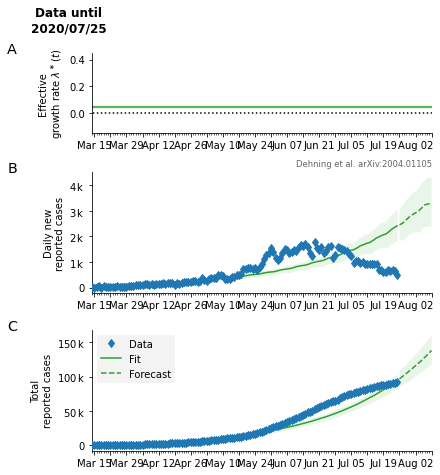

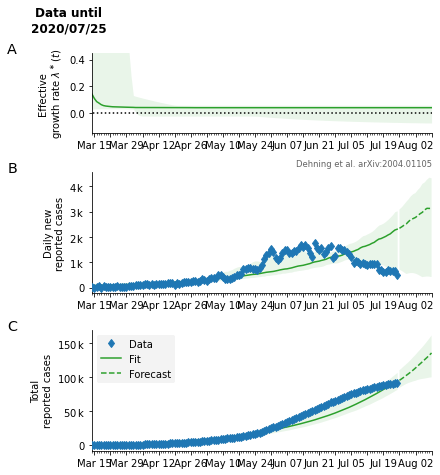

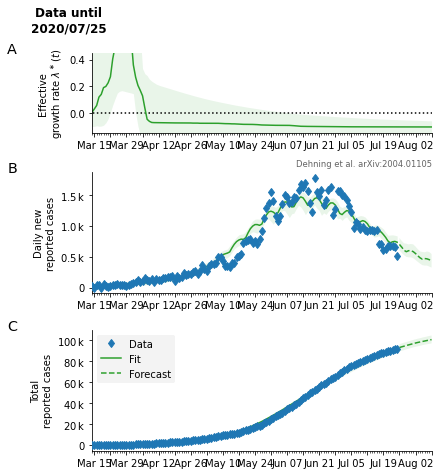

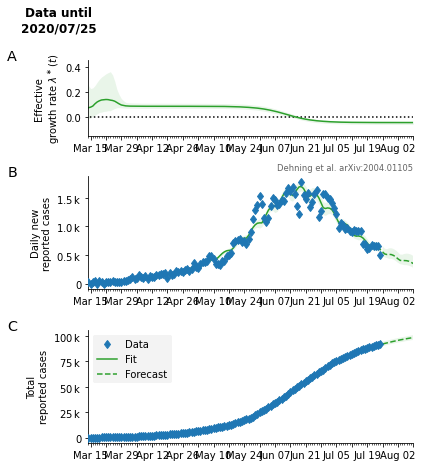

In [ ]:
for model, trace in zip(models, traces):
  fig, axes = cov19.plot.timeseries_overview(model, trace)

fig.tight_layout()

# Posterior Distribution of All SEIR parameters

In [ ]:
def plot_distributions(model, trace, color=None):
    fig, axes = plt.subplots(6, 3, figsize=(10, 8))
  
    left_vars = ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
    mid_vars = ["offset_modulation","sigma_obs","I_begin","transient_day_1","transient_day_2","transient_day_3"]
    right_vars =  ["delay", "transient_len_1", "transient_len_2", "transient_len_3"]

    for i, key in enumerate(left_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i, 0], color=color)

    for i, key in enumerate(mid_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i, 1], color=color)

    for i, key in enumerate(right_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i+2, 2], color=color)

    fig.tight_layout()

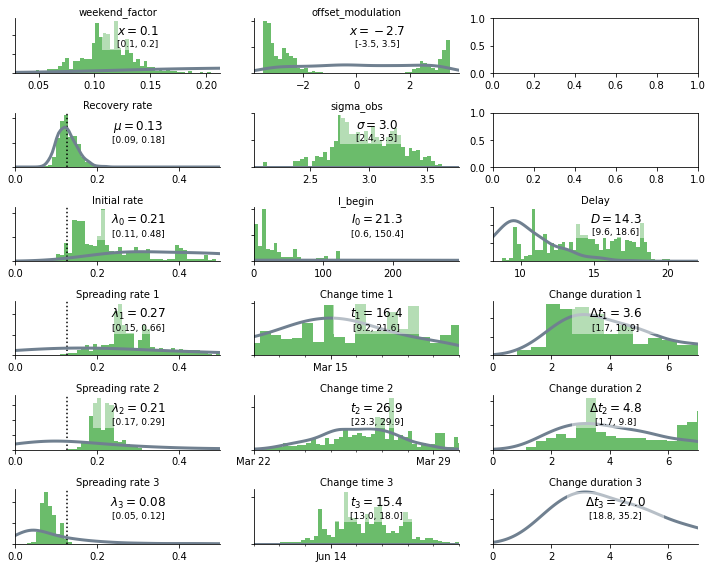

In [ ]:
plot_distributions(models[3], traces[3])

# Model Evaluation to select the best Number of Change Point to use in our Analysis  

In [ ]:
#this is for checking the precision of the changepoint
def truncate_number(number, precision):
    return "{{:.{}f}}".format(precision).format(number)

def print_median_CI(arr, prec=2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = (
        f_trunc(np.percentile(arr, q=2.5)),
        f_trunc(np.percentile(arr, q=97.5)),
    )
    return "Median: {}\nCI: [{}, {}]".format(med, perc1, perc2)

In [ ]:
for i in range(4):
    print(f"\nnumber of changepoints: {i}")
    for j in range(i+1):
        print(f'lambda* {j}')
        print(print_median_CI(traces[i][f"lambda_{j}"] - traces[i].mu, prec=2))


number of changepoints: 0
lambda* 0
Median: 0.04
CI: [0.03, 0.06]

number of changepoints: 1
lambda* 0
Median: 0.25
CI: [0.01, 1.49]
lambda* 1
Median: 0.04
CI: [-0.08, 0.06]

number of changepoints: 2
lambda* 0
Median: 0.23
CI: [-0.07, 0.93]
lambda* 1
Median: 1.85
CI: [0.78, 10.50]
lambda* 2
Median: -0.10
CI: [-0.23, -0.07]

number of changepoints: 3
lambda* 0
Median: 0.07
CI: [-0.03, 0.36]
lambda* 1
Median: 0.15
CI: [0.03, 0.52]
lambda* 2
Median: 0.08
CI: [0.07, 0.11]
lambda* 3
Median: -0.05
CI: [-0.06, -0.03]


It is very clear with the plot's that increase the Change points help make more accurate analysis, it is important we incorparate this change point so we can truly prove them, because our model doesn't help us find them unless we ask it to.

It only helps us validate how effective it was and the rate of spread at that time and when the effect of the policy  yielded result, ie. the time it took to see the change.

In [ ]:
print('\n0 step model\n')
print(pm.loo(traces[0], models[0]))

print('\n1 step model\n')
print(pm.loo(traces[1], models[1]))

print('\n2 steps model\n')
print(pm.loo(traces[2], models[2]))

print('\n3 steps model\n')
print(pm.loo(traces[3], models[3]))


0 step model

Computed from 800 by 134 log-likelihood matrix

         Estimate       SE
elpd_loo  -975.37    14.15
p_loo        8.60        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      134  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

1 step model

Computed from 800 by 134 log-likelihood matrix

         Estimate       SE
elpd_loo  -966.60    13.74
p_loo       40.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      129   96.3%
 (0.5, 0.7]   (ok)          3    2.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)  

The above metric helps us choose the number of change point, by showing us how useful our parameters have been and how similar the prior is to the posterior. You learn more about this here 
[Leave one out Metrics](https://mc-stan.org/loo/reference/loo-glossary.html)
